In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


Load Train Data

In [2]:
res = pd.read_csv('Features_Train.csv')

In [3]:
res.head(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097
0,0,0.0,0.114408,0.0,3.292675,0.0,0.00000,4.257201,0.0,0.0,...,0.767424,0.118912,0.000000,4.596314,0.0,1.627453,0.0,0.0,CNV-1016042-1.jpeg,CNV
1,1,0.0,0.000000,0.0,1.633569,0.0,1.77213,3.954456,0.0,0.0,...,2.151354,0.000000,1.645714,3.223092,0.0,1.610794,0.0,0.0,CNV-1016042-10.jpeg,CNV


The data is biased, so I will downsample to get an event distribution of the data

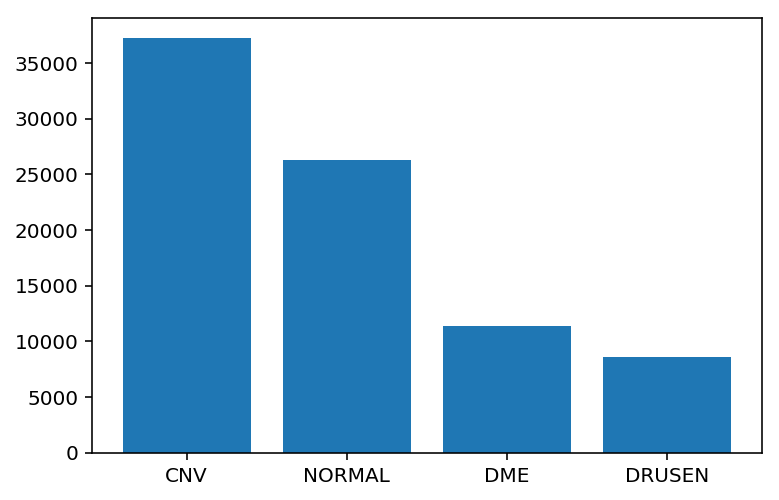

In [4]:
def data_hist(df):
    vals = df['4097'].value_counts().values
    ind = df['4097'].value_counts().index
    plt.bar(range(len(ind)),vals,tick_label = ind)
data_hist(res)

We will only get the first 8616 samples from each group

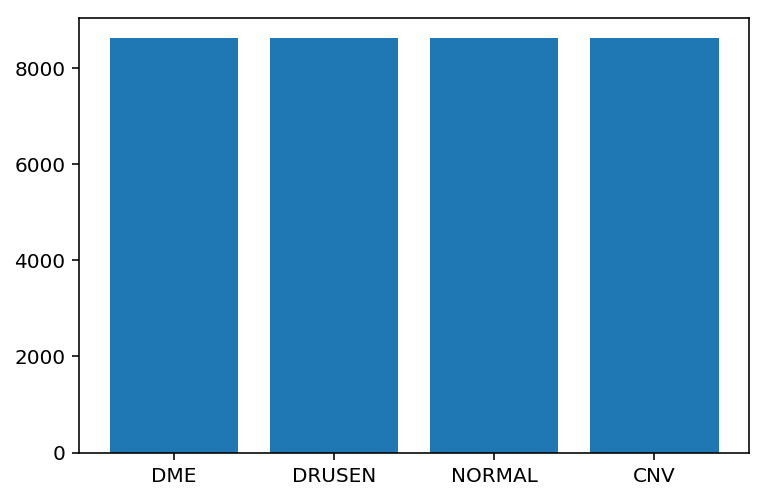

In [5]:
res2 = res[res['4097']=='CNV'].iloc[0:8616]
res2 = pd.concat([res2,res[res['4097']=='NORMAL'].iloc[0:8616]])
res2 = pd.concat([res2,res[res['4097']=='DME'].iloc[0:8616]])
res2 = pd.concat([res2,res[res['4097']=='DRUSEN'].iloc[0:8616]])
res = res2
data_hist(res)

Separate X and y

In [6]:
X_train = res.copy()
X_train.drop(['Unnamed: 0','4096','4097'],axis=1, inplace=True)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.0,0.114408,0.000000,3.292675,0.0,0.000000,4.257201,0.0,0.0,0.000000,...,0.628115,1.726063,0.767424,0.118912,0.000000,4.596314,0.0,1.627453,0.0,0.0
1,0.0,0.000000,0.000000,1.633569,0.0,1.772130,3.954456,0.0,0.0,0.000000,...,0.000000,2.236545,2.151354,0.000000,1.645714,3.223092,0.0,1.610794,0.0,0.0
2,0.0,0.000000,0.381786,2.241905,0.0,3.030623,2.597111,0.0,0.0,0.000000,...,0.000000,0.998484,3.078707,0.481898,0.000000,1.232019,0.0,0.628986,0.0,0.0
3,0.0,0.000000,0.000000,2.430932,0.0,0.772482,4.422484,0.0,0.0,2.489886,...,1.285890,1.614993,0.000000,1.050188,0.000000,3.625432,0.0,3.412659,0.0,0.0
4,0.0,0.000000,0.000000,2.430932,0.0,0.772482,4.422484,0.0,0.0,2.489886,...,1.285890,1.614993,0.000000,1.050188,0.000000,3.625432,0.0,3.412659,0.0,0.0


In [7]:
y_train = res['4097'].copy()
y_train.value_counts()

DME       8616
DRUSEN    8616
NORMAL    8616
CNV       8616
Name: 4097, dtype: int64

Load the test data

In [8]:
res = pd.read_csv('Features_Test.csv')

In [9]:
res.head(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097
0,0,0.0,0.0,0.0,2.906517,0.0,0.420020,4.296966,0.0,0.0,...,0.473824,0.888168,0.217223,2.689590,0.0,1.375198,0.0,0.0,CNV-1016042-1.jpeg,CNV
1,1,0.0,0.0,0.0,3.241205,0.0,2.919435,4.524708,0.0,0.0,...,0.000000,1.149813,0.000000,2.573175,0.0,2.244271,0.0,0.0,CNV-1016042-2.jpeg,CNV


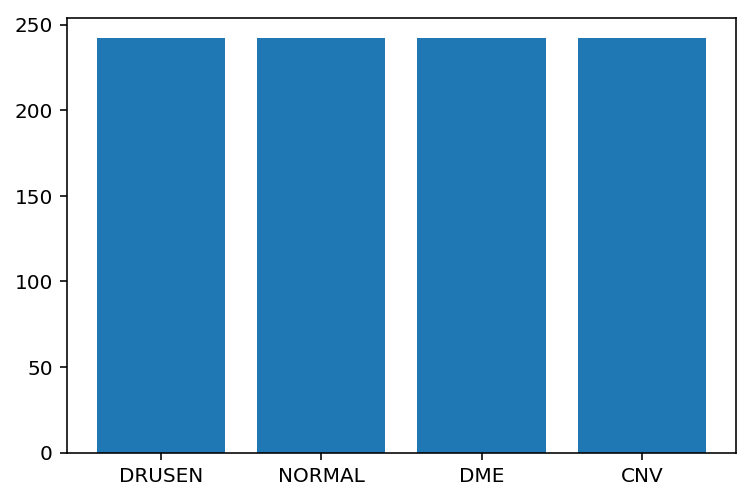

In [10]:
data_hist(res)

Separate X and y

In [11]:
X_test = res.copy()
X_test.drop(['Unnamed: 0','4096','4097'],axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.000000,0.0,0.0,2.906517,0.000000,0.420020,4.296966,0.0,0.0,0.000000,...,0.000000,0.421530,0.473824,0.888168,0.217223,2.689590,0.0,1.375198,0.0,0.0
1,0.000000,0.0,0.0,3.241205,0.000000,2.919435,4.524708,0.0,0.0,2.697443,...,2.895439,0.116249,0.000000,1.149813,0.000000,2.573175,0.0,2.244271,0.0,0.0
2,0.000000,0.0,0.0,6.405076,0.366281,0.000000,7.313044,0.0,0.0,3.600244,...,0.000000,0.000000,2.894467,2.040965,1.211218,0.555682,0.0,1.679613,0.0,0.0
3,0.000000,0.0,0.0,3.187257,0.000000,1.536624,4.851705,0.0,0.0,1.822675,...,1.210716,1.633535,0.000000,0.068944,0.000000,4.552268,0.0,2.679543,0.0,0.0
4,0.467271,0.0,0.0,3.739561,0.000000,0.291195,4.140689,0.0,0.0,1.292297,...,0.000000,2.045183,0.000000,0.021926,0.173606,2.972565,0.0,5.274068,0.0,0.0


In [12]:
y_test = res['4097'].copy()
y_test.value_counts()

DRUSEN    242
NORMAL    242
DME       242
CNV       242
Name: 4097, dtype: int64

PCA for Dimensionality Reduction

In [13]:
n_components=150
pca_model = PCA(n_components=n_components)
X_train = pca_model.fit_transform(X_train)
X_test = pca_model.transform(X_test)

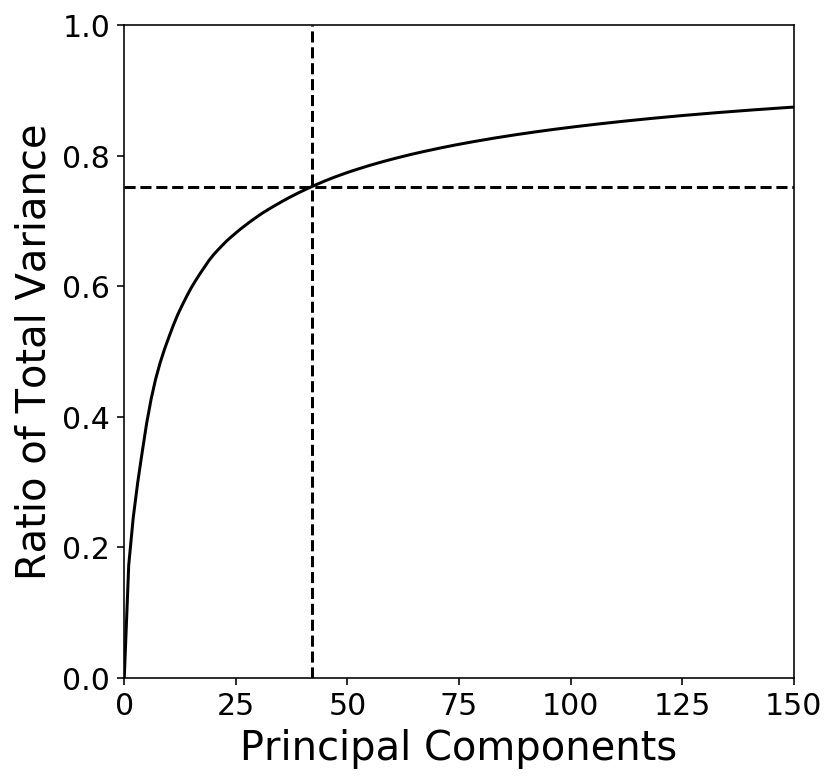

In [14]:
PCA_var = pca_model.explained_variance_ratio_
PCA_var=np.insert(PCA_var,0,0)
PCA_var_cumsum = np.cumsum(PCA_var)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize=[6,6])
plt.plot(PCA_var_cumsum,'k')
plt.plot([42,42],[0,1],'k--')
plt.plot([0,n_components],[PCA_var_cumsum[42],PCA_var_cumsum[42]],'k--')
plt.axis([0,n_components,0,1])
plt.xlabel('Principal Components',fontsize=20)
plt.ylabel('Ratio of Total Variance',fontsize=20)
plt.savefig('PCA.jpg')

In [15]:
PCA_var_cumsum[150]

0.87458521474859829

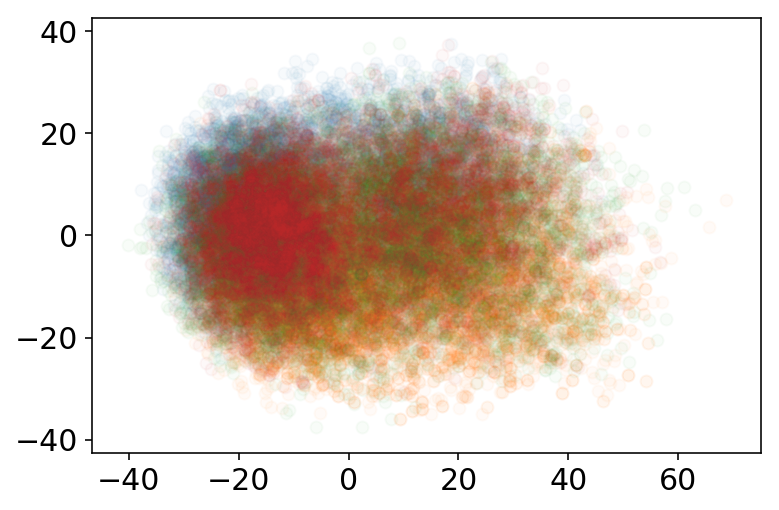

In [16]:
alpha = 0.03
loc = y_train =='NORMAL'
plt.scatter(X_train[loc,0],X_train[loc,1],alpha = alpha)
loc = y_train =='CNV'
plt.scatter(X_train[loc,0],X_train[loc,1],alpha = alpha)
loc = y_train =='DME'
plt.scatter(X_train[loc,0],X_train[loc,1],alpha = alpha)
loc = y_train =='DRUSEN'
plt.scatter(X_train[loc,0],X_train[loc,1],alpha = alpha)

In [17]:
n_components=150#42
pca_model = PCA(n_components=n_components)
X_train = pca_model.fit_transform(X_train)
X_test = pca_model.transform(X_test)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [100, 200, 300, 400],
#     'max_depth': [30],
#     'n_estimators': [400, 500],

}

In [ ]:
# Create a based model
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

In [ ]:
grid_search.cv_results_

In [ ]:
grid_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'micro') 

print(grid_accuracy, f1)

In [ ]:
print(best_grid)

In [22]:
# rf = GradientBoostingClassifier(n_estimators = 500,random_state=42)

rf = RandomForestClassifier(max_depth = 25, n_estimators = 500,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.952479338843


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[226   7   8   1]
 [  6 222   2  12]
 [  3   0 239   0]
 [  0   1   6 235]]


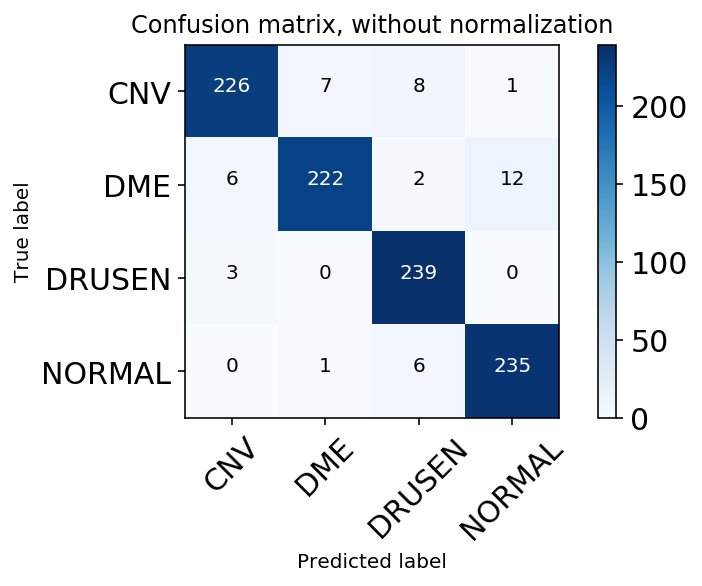

In [24]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(),
                      title='Confusion matrix, without normalization')

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2,learning_rate=1000,random_state=42,early_exaggeration=1,n_iter=2000)

####### Normalize the X_train????? Standard Scaler
X_2 = tsne_model.fit_transform(X_train)

In [ ]:
loc = y_train =='normal'
plt.scatter(X_2[loc,0],X_2[loc,1])
loc = y_train =='DR'
plt.scatter(X_2[loc,0],X_2[loc,1])